In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl, matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = (16,12)
plt.rcParams["figure.edgecolor"] = "black"
plt.rcParams["figure.titlesize"] = 20
plt.rcParams["figure.titleweight"] = "bold"
plt.rcParams["axes.labelsize"] = 18
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12

%matplotlib inline

from sklearn import preprocessing

In [2]:
tvdb_series_df = pd.read_csv("data/output/tvdb_series.csv", index_col="imdb_id")
my_ratings_df = pd.read_csv("data/input/my_ratings.csv", index_col="imdb_id")
imdb_series_df = pd.read_csv("data/output/imdb_series.csv", index_col="id")

In [3]:
cols_to_use = tvdb_series_df.columns.difference(imdb_series_df.columns)
df1 = pd.merge(imdb_series_df, tvdb_series_df[cols_to_use], how="outer", left_index=True, right_index=True)

cols_to_use = my_ratings_df.columns.difference(df1.columns)
tv_df = pd.merge(df1, my_ratings_df[cols_to_use], how="outer", left_index=True, right_index=True)
tv_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1937 entries, tt0092337 to tt9879074
Data columns (total 86 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               1936 non-null   object 
 1   type               1936 non-null   object 
 2   start_year         1936 non-null   float64
 3   end_year           1084 non-null   float64
 4   ep_length          1936 non-null   float64
 5   n_seasons          1936 non-null   object 
 6   n_episodes         1936 non-null   float64
 7   popularity_rank    1936 non-null   float64
 8   n_ratings          1936 non-null   float64
 9   rating_avg         1936 non-null   float64
 10  rating_top1000     1936 non-null   float64
 11  rating_us          1936 non-null   float64
 12  rating_row         1936 non-null   float64
 13  rating_M           1936 non-null   float64
 14  rating_F           1936 non-null   float64
 15  rating_0to18       1936 non-null   object 
 16  rating_M_0to18  

# Correlation

In [4]:
corr_matrix = tv_df.corr()

In [5]:
my_rating_corr = corr_matrix["my_rating"]
genres_mask = corr_matrix.filter(like="genre").columns
rating_mask = corr_matrix.filter(like="rating").columns

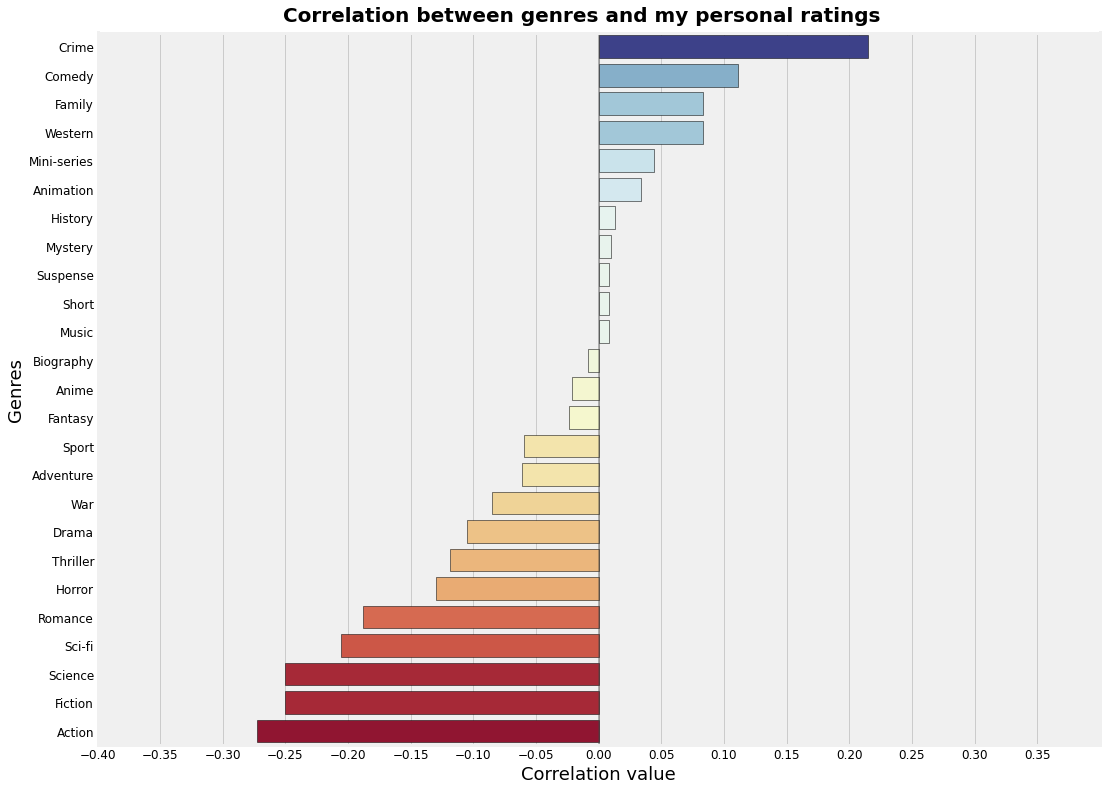

In [13]:
# Sort values.
sorted_corr_genres = my_rating_corr[genres_mask].sort_values(ascending=False)
# Remove nan values.
sorted_corr_genres = sorted_corr_genres[np.logical_not(np.isnan(sorted_corr_genres))]
# Normalize values to assign proper colors.
norm_sorted_corr_genres = preprocessing.MinMaxScaler().fit_transform(sorted_corr_genres.values.reshape(-1,1)).flatten()
# Prettify labels on y axis.
labels = [l.split("_")[1].capitalize() for l in sorted_corr_genres.index]

fig, ax = plt.subplots(figsize=(16,12))

sns.barplot(y=labels, x=sorted_corr_genres, ax=ax, palette=mpl.cm.RdYlBu(norm_sorted_corr_genres), edgecolor="black")
ax.axvline(color='#414141', linewidth=1.5, alpha=.5)

plt.suptitle("Correlation between genres and my personal ratings")
plt.subplots_adjust(top=0.95)
ax.set_xlim(-0.4,0.4)
ax.xaxis.set_ticks(np.arange(-0.4, 0.4, 0.05))
ax.set_xlabel("Correlation value")
ax.set_ylabel("Genres")

plt.show()

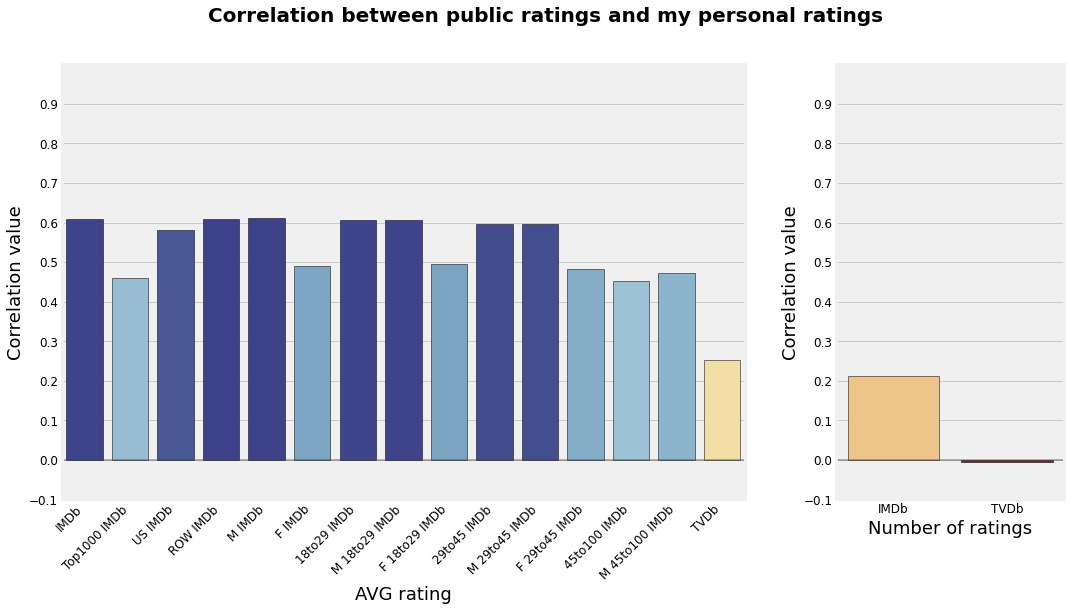

In [7]:
sorted_corr_rating = my_rating_corr[rating_mask].drop("my_rating")
norm_sorted_corr_rating = preprocessing.MinMaxScaler().fit_transform(sorted_corr_rating.values.reshape(-1,1)).flatten()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8), gridspec_kw={"width_ratios": [3, 1]})
plt.suptitle("Correlation between public ratings and my personal ratings")

# PLOT 1
y1 = sorted_corr_rating[1:-1]
x1 = ["IMDb", "Top1000 IMDb", "US IMDb", "ROW IMDb", "M IMDb", "F IMDb", "18to29 IMDb", "M 18to29 IMDb", "F 18to29 IMDb", 
      "29to45 IMDb", "M 29to45 IMDb", "F 29to45 IMDb", "45to100 IMDb", "M 45to100 IMDb", "TVDb"]
palette1 = mpl.cm.RdYlBu(norm_sorted_corr_rating[1:-1])

sns.barplot(y=y1, x=x1, ax=ax1, palette=palette1, edgecolor="black")
ax1.axhline(color='#414141', linewidth=1.5, alpha=.5)

ax1.set_xlabel("AVG rating")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.set_ylim(-0.1,1.0)
ax1.yaxis.set_ticks(np.arange(-0.1, 1.0, 0.10))
ax1.set_ylabel("Correlation value")

# PLOT 2
x2 = ["IMDb", "TVDb"]
y2 = list((sorted_corr_rating[0], sorted_corr_rating[-1]))
palette2 = mpl.cm.RdYlBu(list((norm_sorted_corr_rating[0], norm_sorted_corr_rating[-1])))

sns.barplot(x=x2, y=y2, ax=ax2, palette=palette2, edgecolor="black")
ax2.axhline(color='#414141', linewidth=1.5, alpha=.5)

ax2.set_ylim(-0.1,1)
ax2.yaxis.set_ticks(np.arange(-0.1, 1, 0.10))
ax2.set_xlabel("Number of ratings")
ax2.set_ylabel("Correlation value")

plt.show()

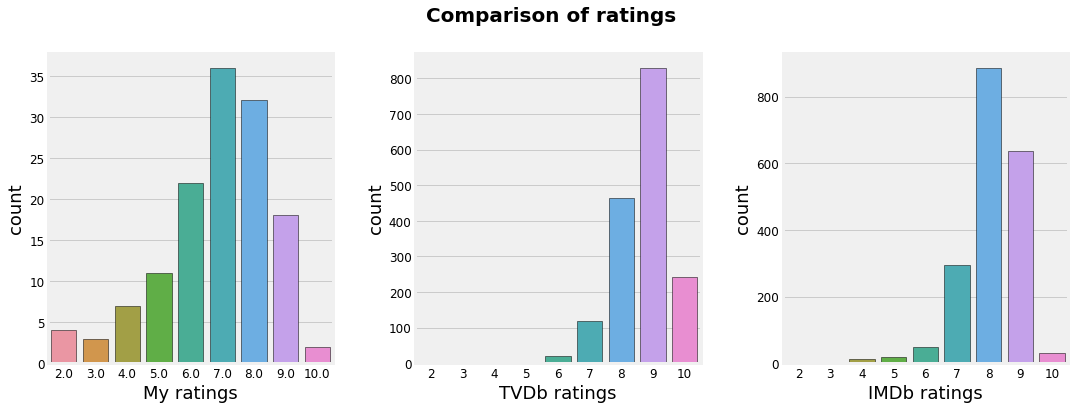

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6), gridspec_kw={"width_ratios": [1, 1, 1]})
fig.tight_layout(pad=5.0)
fig.suptitle("Comparison of ratings")

sns.countplot(tv_df["my_rating"], ax=ax1, edgecolor="#000000")
ax1.set_xlabel("My ratings")

# Discretizing and plotting TVDb ratings.
disc = pd.cut(tv_df["tvdb_avg_rating"], bins=range(1,11))
sns.countplot(disc.map(lambda x: x.right), ax=ax2, edgecolor="#000000")
ax2.set_xlabel("TVDb ratings")

# Discretizing and plotting IMDb ratings.
disc = pd.cut(tv_df["rating_avg"], bins=range(1,11))
sns.countplot(disc.map(lambda x: x.right), ax=ax3, edgecolor="#000000")
ax3.set_xlabel("IMDb ratings")

plt.show()

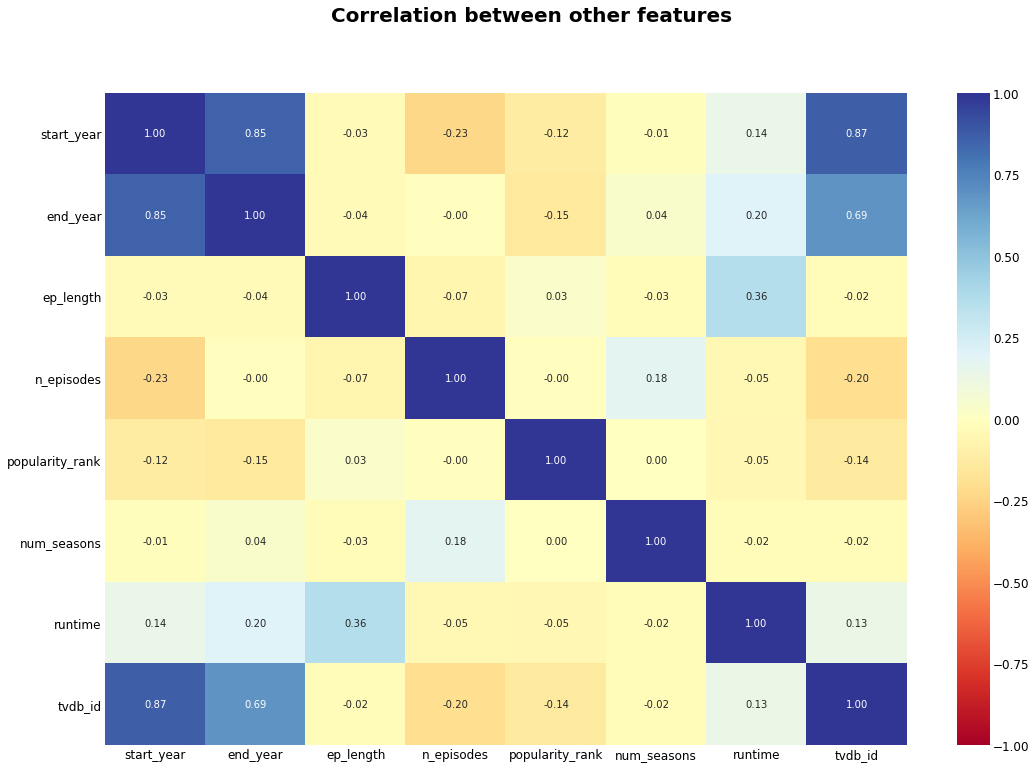

In [9]:
fig, ax = plt.subplots(figsize=(16, 12))
mask = rating_mask.append(genres_mask)
plt.suptitle("Correlation between other features", x=0.45, ha="center")

ax = sns.heatmap(tv_df.drop(mask, axis=1).corr(), annot=True, fmt=".2f", vmin=-1, vmax=1, cmap="RdYlBu")
plt.show()

### Insights
start_year and end_year have a high correlation, as expected.

start_year has also a high positive correlation with tvdb_id, meaning that ids on tvdb.com are assigned incrementally as soon as new tv series are announced.

ep_length is lightly correlated with runtime. This is strange, because the correlation should be higher, given that these two features should represent the same thing on different websites (ep_length is taken from IMDb, while runtime is taken from TVDb).

Surprisingly, num_seasons is not heavily correlated to n_episodes.

My ratings are negatively correlated with year and popularity_rank, meaning that I tend to enjoy less recent and popular tv series. 
There may be a bias here, because I only watch old tv series if they are critically acclaimed, while I am more "risk prone" with recent series.

## Interesting data

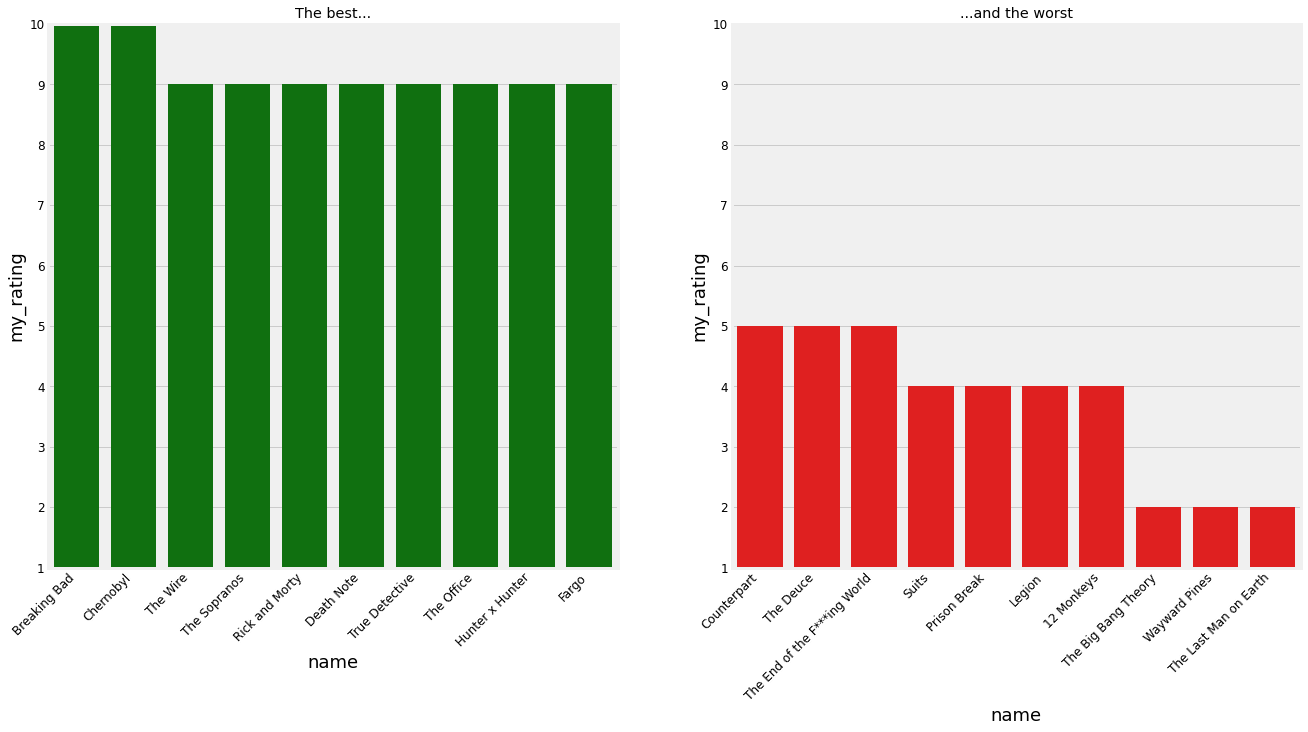

In [10]:
best = tv_df.sort_values(by=["my_rating", "rating_avg"], ascending=False)[:10]
worst = tv_df.dropna().sort_values(by=["my_rating", "rating_avg"], ascending=False)[-10:]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

subset = best.append(worst)

# PLOT 1
sns.barplot(x="name", y="my_rating", data=best, ax=ax1, color="green")
ax1.set_title("The best...")
ax1.set_ylim(1,10)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# PLOT 2
sns.barplot(x="name", y="my_rating", data=worst, ax=ax2, color="red")
ax2.set_title("...and the worst")
ax2.set_ylim(1,10)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

plt.show()

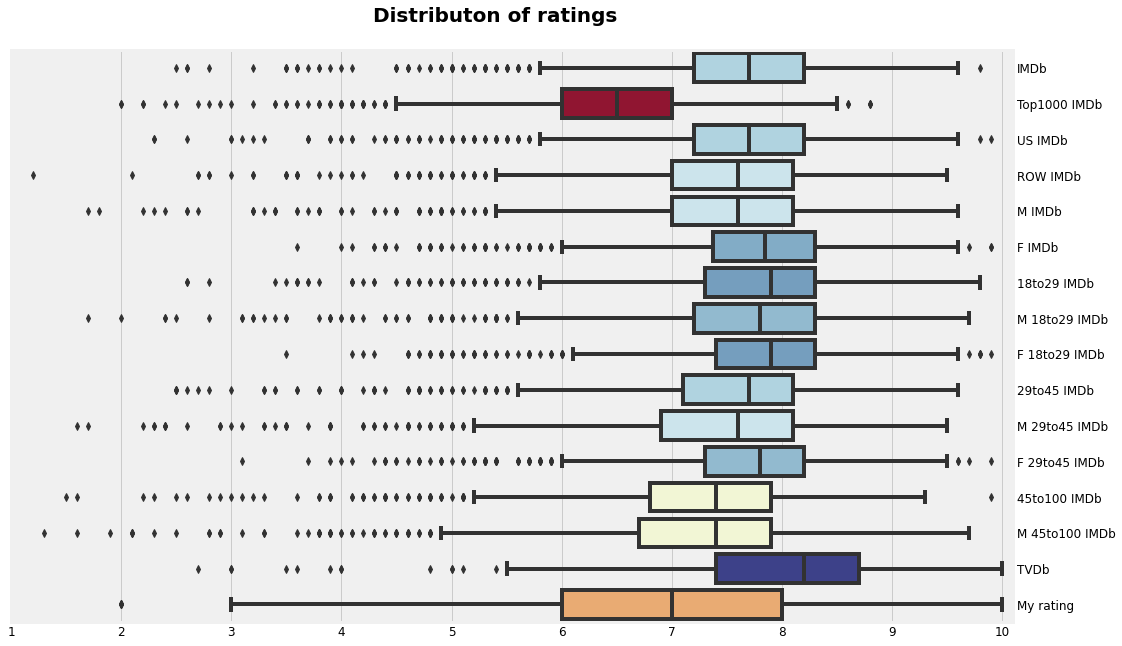

In [11]:
fig, ax = plt.subplots(figsize=(16, 10))

cols = list(rating_mask.drop(["n_ratings", "tvdb_ratings"]))
medians = tv_df[cols].median()
norm_medians = preprocessing.MinMaxScaler().fit_transform(medians.values.reshape(-1,1)).flatten()
palette = mpl.cm.RdYlBu(norm_medians)
labels = ["IMDb", "Top1000 IMDb", "US IMDb", "ROW IMDb", "M IMDb", "F IMDb", "18to29 IMDb", "M 18to29 IMDb", "F 18to29 IMDb", 
          "29to45 IMDb", "M 29to45 IMDb", "F 29to45 IMDb", "45to100 IMDb", "M 45to100 IMDb", "TVDb", "My rating"]

sns.boxplot(data=tv_df[cols], orient="h", palette=palette)

plt.suptitle("Distributon of ratings")
plt.subplots_adjust(top=0.92)
ax.set_xlim(1,10.1)
ax.xaxis.set_ticks(np.arange(1, 11, 1))
ax.set_yticklabels(labels)
ax.yaxis.tick_right()

plt.show()

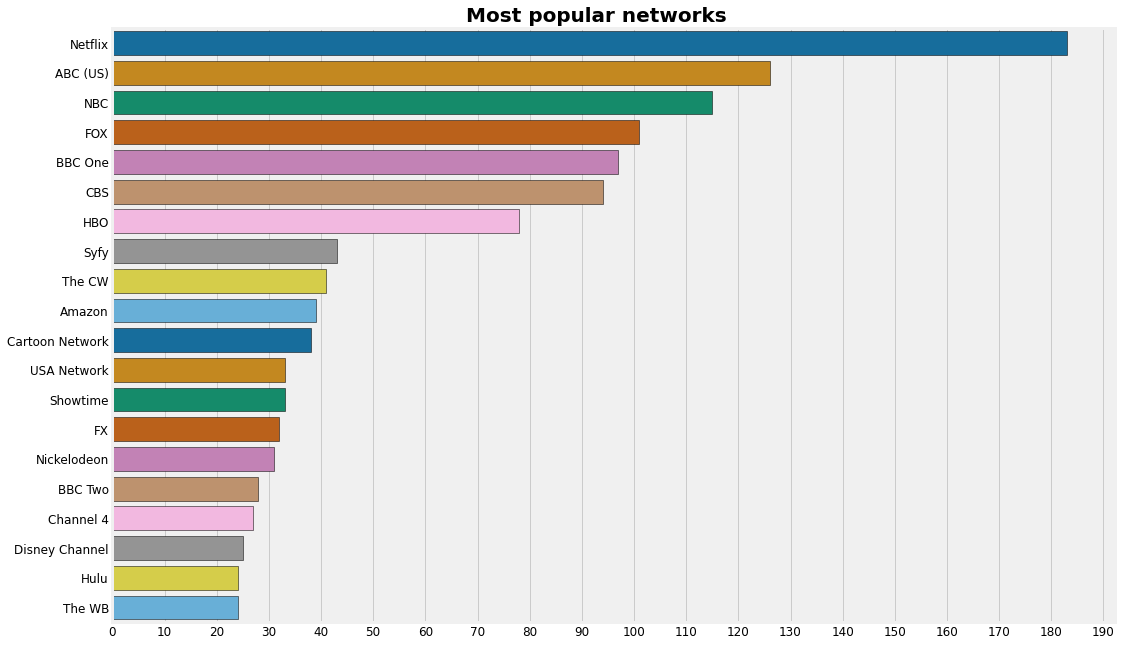

In [12]:
fig, ax = plt.subplots(figsize=(16,10))

values = tv_df["network"].value_counts()[:20]

sns.barplot(x=values.values, y=values.index, palette="colorblind", edgecolor="black")

plt.suptitle("Most popular networks")
plt.subplots_adjust(top=0.95)
ax.xaxis.set_ticks(np.arange(0,200,10))

plt.show()